This example uses data from the GEFCom2014 forecasting competition1. It is made up of three years of hourly electrical load and temperature information from 2012 to 2014. The aim is to forecast future electricity load values.

In this notebook, we demonstrate how to:

- Prepare time series data for Linear Regression and Convolutional Neural Network (CNN) forecasting model training

- Get data in the proper format for the Keras API

- Use a Linear Regression and CNN model to predict the next step in the time series (time t+1).

- Allow for early stopping to limit the risk of model overfitting.

- Test the models on a test dataset

- Stacking models: improve model predictions by combining the outputs of multiple models (Linear Regression and CNN)


**NOTE: Remember that CNN models are stochastic, so each simulation may give you slightly different results in MAPE.** 

In [81]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
from collections import UserDict
from IPython.display import Image
import statsmodels.api as sm
%matplotlib inline

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
energy = pd.read_excel('/kaggle/input/gefcom2014/GEFCom2014-E.xlsx', header=0)

In [3]:
energy.head()

,Date,Hour,load,T
0,2004-01-01,1,NaN,37.33
1,2004-01-01,2,NaN,37.67
2,2004-01-01,3,NaN,37.00
3,2004-01-01,4,NaN,36.33
4,2004-01-01,5,NaN,36.00


In [4]:
#Create timestamp variable from Date and Hour
energy['timestamp'] = energy['Date'].add(pd.to_timedelta(energy.Hour - 1, unit='h'))
#Remove time period with no load data
energy = energy[energy.timestamp >= '2012-01-01']
#Select target rows
energy = energy.loc[:,['timestamp','load']]

In [5]:
#Set timestamp as index
energy = energy.set_index('timestamp')

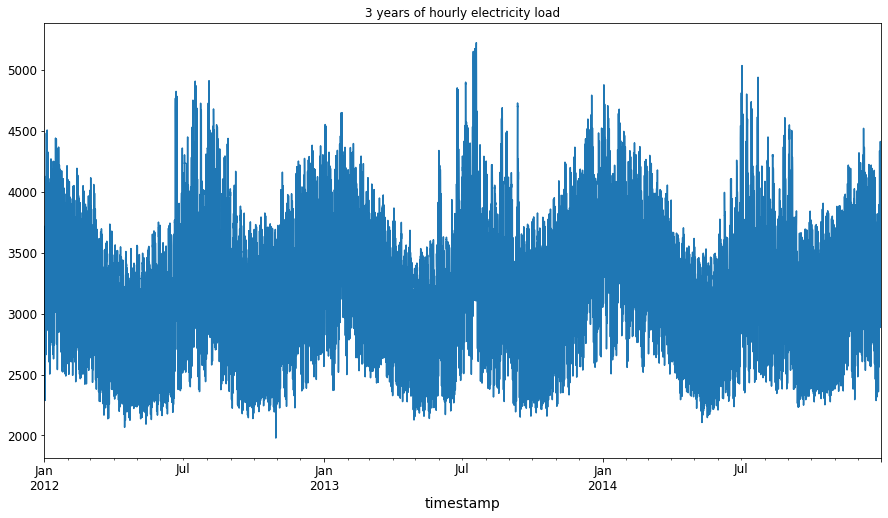

In [6]:
y = energy.loc[:, 'load'] # target
ax = y.plot(figsize=(15, 8))
ax.set_title('3 years of hourly electricity load');

# Visualize train, validation and test sets 

In [7]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

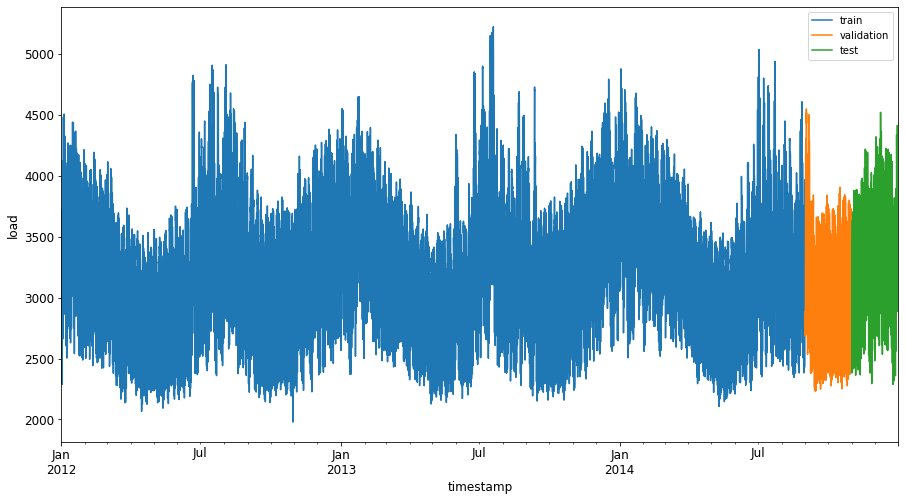

In [8]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [9]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

In [10]:
train.describe()

,load
count,"23,376.00"
mean,"3,309.19"
std,570.25
min,"1,979.00"
25%,"2,870.75"
50%,"3,362.00"
75%,"3,698.00"
max,"5,224.00"


# Feature engineering and data analysis

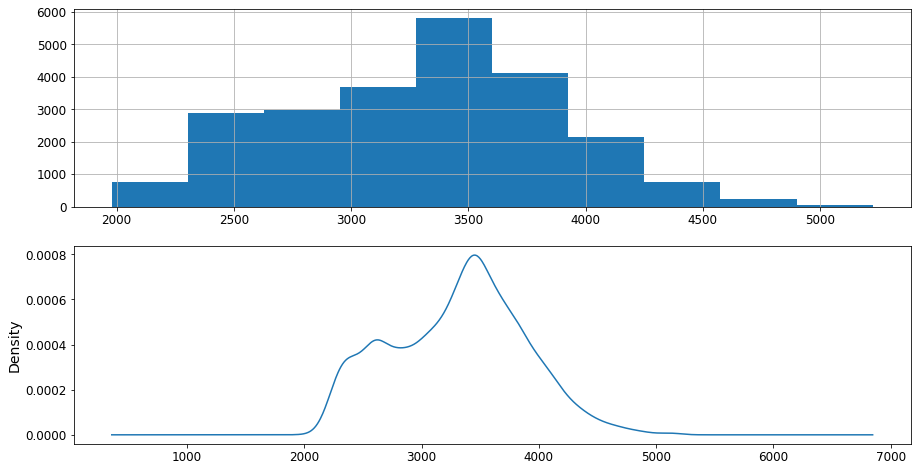

In [11]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1, figsize=(15, 8))
pyplot.subplot(211)
train.load.hist()
pyplot.subplot(212)
train.load.plot(kind='kde')
pyplot.show()



The distribution is Gaussian (normal distribution), with some imperfection in the left tail




**Scaling the time series from 0 to 1**

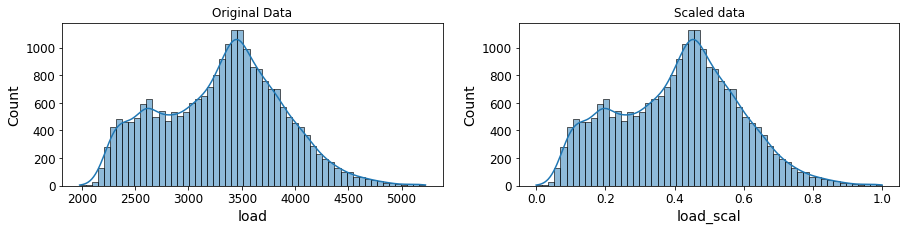

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# mix-max scale the data between 0 and 1
train['load_scal'] = scaler.fit_transform(train)


# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(train['load'], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(train['load_scal'], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()

In [13]:
train.drop('load', axis = 1, inplace = True)

**ACF and PACF plots**

In general, if the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

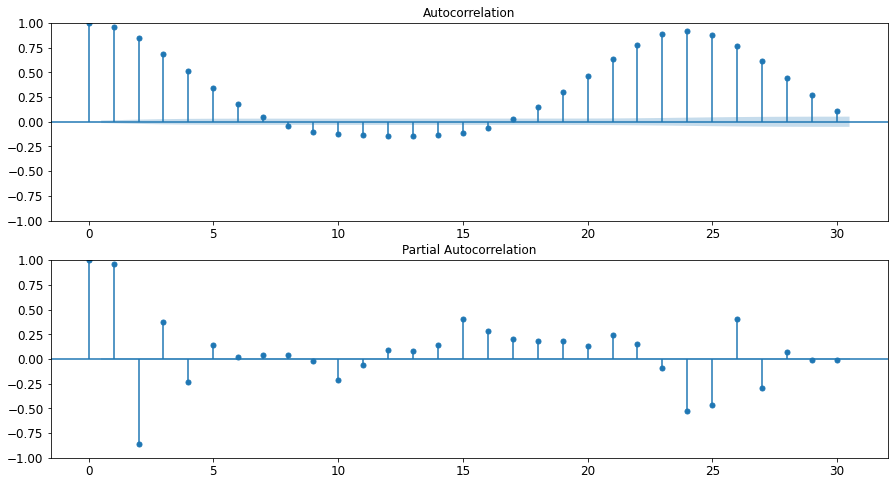

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure(figsize=(15, 8))
pyplot.subplot(211)
plot_acf(train.load_scal, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(train.load_scal, ax=pyplot.gca(), lags = 30)
pyplot.show()

**Trend analysis**

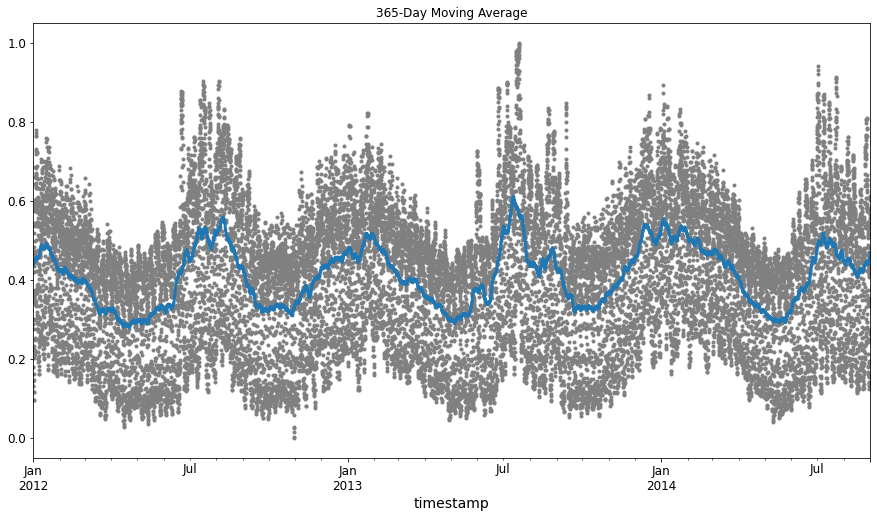

In [15]:
moving_average = train['load_scal'].rolling(
    window=365, # 365-day window
    center=True, # puts the average at the center of the window
    min_periods=183, # choose about half the window size
).mean() # compute the mean (could also do median, std, min, max, ...)
pyplot.figure(figsize=(15, 8))
ax = train['load_scal'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="365-Day Moving Average", legend=False,
);

The trend is not linear, so we should assume that the time series is stationary, but let us apply another test to confirm it

**Augmented Dickey-Fuller Test**

- The intuition behind the test is that if the series is integrated then the 
lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).

- Null hypothesis: The time series is not stationary

- Rejecting the null hypothesis (i.e. a very low p-value) will indicate stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(train['load_scal'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -10.70
p-value                            0.00
#Lags Used                        45.00
Number of Observations Used   23,330.00
Critical Value (1%)               -3.43
Critical Value (5%)               -2.86
Critical Value (10%)              -2.57
dtype: float64


The test shows that the time series is stationary

**Create lags features**: For this example, we will set T=10. This means that the input for each sample is a vector of the previous 10 hours of the energy load. The choice of T=10 was arbitrary but should be selected through experimentation.

HORIZON=1 specifies that we have a forecasting horizon of 1 (t+1)

Using the freq parameter we can tell Pandas that the frequency of the time series is hourly

In [17]:
#Prepare training inputs
T = 10
HORIZON = 1
df = train.copy()
def make_lags(df, HORIZON, T):
  df['y_t+1'] = df['load_scal'].shift(-HORIZON, freq='H')
  for t in range(1, T+1):
    df['load_t-'+str(T-t)] = df['load_scal'].shift(T-t, freq='H')
  df.dropna(how='any', inplace = True)
  return df

train_shifted = make_lags(df, HORIZON, T)

# Prepare data for Linear Regression

In [18]:
#Prepare training inputs
y_train = train_shifted[['y_t+1']].values
X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]]

In [19]:
y_train.shape

(23366, 1)

In [20]:
X_train.shape

(23366, 10)

**Validation set**

In [21]:
look_back_dt = dt.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
timestamp,
2014-08-31 15:00:00,"3,813.00"
2014-08-31 16:00:00,"3,859.00"
2014-08-31 17:00:00,"3,936.00"
2014-08-31 18:00:00,"3,957.00"
2014-08-31 19:00:00,"3,969.00"


In [22]:
#Scale the series using the transformer fitted on the training set

valid['load_scal'] = scaler.transform(valid)
valid.drop('load', axis = 1, inplace = True)
valid.head()

,load_scal
timestamp,
2014-08-31 15:00:00,0.57
2014-08-31 16:00:00,0.58
2014-08-31 17:00:00,0.60
2014-08-31 18:00:00,0.61
2014-08-31 19:00:00,0.61


In [23]:
#Prepare validation inputs

T = 10
HORIZON = 1
df = valid.copy()
def make_lags(df, HORIZON, T):
  df['y_t+1'] = df['load_scal'].shift(-HORIZON, freq='H')
  for t in range(1, T+1):
    df['load_t-'+str(T-t)] = df['load_scal'].shift(T-t, freq='H')
  df.dropna(how='any', inplace = True)
  return df

valid_shifted = make_lags(df, HORIZON, T)

In [24]:
y_valid = valid_shifted[['y_t+1']]
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]]

In [25]:
y_valid.shape

(1463, 1)

In [26]:
X_valid.shape

(1463, 10)

**Test set**

In [27]:
look_back_dt = dt.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

,load
timestamp,
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"


In [28]:
#Scale the series using the transformer fitted on the training set

test['load_scal'] = scaler.transform(test)
test.drop('load', axis = 1, inplace = True)
test.head()

,load_scal
timestamp,
2014-11-01 00:00:00,0.16
2014-11-01 01:00:00,0.14
2014-11-01 02:00:00,0.13
2014-11-01 03:00:00,0.12
2014-11-01 04:00:00,0.14


In [29]:
#Prepare test inputs

T = 10
HORIZON = 1
df = test.copy()
def make_lags(df, HORIZON, T):
  df['y_t+1'] = df['load_scal'].shift(-HORIZON, freq='H')
  for t in range(1, T+1):
    df['load_t-'+str(T-t)] = df['load_scal'].shift(T-t, freq='H')
  df.dropna(how='any', inplace = True)
  return df

test_shifted = make_lags(df, HORIZON, T)

In [30]:
y_test = test_shifted[['y_t+1']].values
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values

In [31]:
y_test.shape

(1454, 1)

In [32]:
X_test.shape

(1454, 10)

**Linear Regression**

In [33]:
#libraries for Linear Regression
from sklearn.linear_model import LinearRegression

In [34]:
#Linear Regression 
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
#Make predictions on test set
predictions_0 = lr.predict(X_test)
#Compare predictions to observed values
eval_df_0 = pd.DataFrame(predictions_0, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df_0['timestamp'] = test_shifted.index
eval_df_0 = pd.melt(eval_df_0, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df_0['actual'] = np.transpose(y_test).ravel()
eval_df_0[['prediction', 'actual']] = scaler.inverse_transform(eval_df_0[['prediction', 'actual']])
eval_df_0.head()

,timestamp,h,prediction,actual
0,2014-11-01 09:00:00,t+1,"3,483.03","3,436.00"
1,2014-11-01 10:00:00,t+1,"3,466.08","3,464.00"
2,2014-11-01 11:00:00,t+1,"3,471.83","3,439.00"
3,2014-11-01 12:00:00,t+1,"3,389.44","3,407.00"
4,2014-11-01 13:00:00,t+1,"3,375.20","3,389.00"


In [36]:
#Compute the mean absolute percentage error over all predictions
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

mape(eval_df_0['prediction'], eval_df_0['actual'])

0.01603458387229503

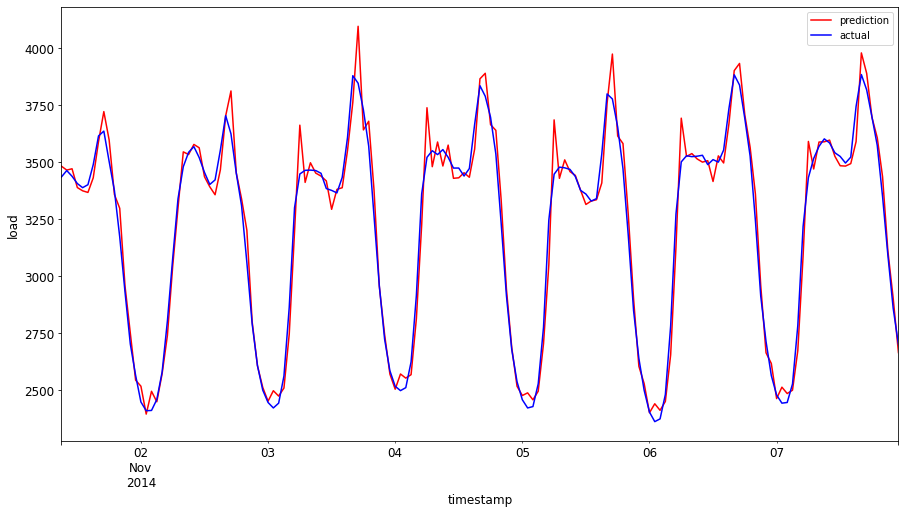

In [37]:
#Plot the predictions vs the observed values for the first week of the test set
eval_df_0[eval_df_0.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Prepare data  for CNN

CNNs require data to have a 3-Dimensional structure instead of the 2-Dimensional structure

The 3-Dimension of the input are:

1) Samples: One sequence is one sample. A batch is comprised of one o more samples

2) Times steps: One time step is one point of observation in the sample. One sample is comprised of multiple time step

3) Features: One feature is one observation at a time step. One time step is comprised of one or more features

In [38]:
#Convert the target variable into a numpy array

y_train = train_shifted[['y_t+1']].values

In [39]:
y_train.shape

(23366, 1)

In [40]:
#Convert the inputs into a numpy array with shape (samples, time steps, features)

X_train = train_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_train = X_train[... , np.newaxis]

In [41]:
X_train.shape

(23366, 10, 1)

Validation set

In [42]:
#Convert the target variable into a numpy array

y_valid = valid_shifted[['y_t+1']].values

In [43]:
y_valid.shape

(1463, 1)

In [44]:
#Convert the inputs into a numpy array with shape (samples, time steps, features)

X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_valid = X_valid[... , np.newaxis]

In [45]:
X_valid.shape

(1463, 10, 1)

**Test set**

In [46]:
#Convert the target variable into a numpy array

y_test = test_shifted[['y_t+1']].values

In [47]:
y_test.shape

(1454, 1)

In [48]:
#Convert the inputs into a numpy array with shape (samples, time steps, features)

X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].values
X_test = X_test[... , np.newaxis]

In [49]:
X_test.shape

(1454, 10, 1)

**Libraries for CNN**

In [54]:
import tensorflow as tf
import sklearn
from tensorflow import keras
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#libraries for CNN
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import  MaxPooling1D, AveragePooling1D, Conv1D
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator

seed = 12
np.random.seed(seed)

LeNet-5

Compressed notation for LeNet-5

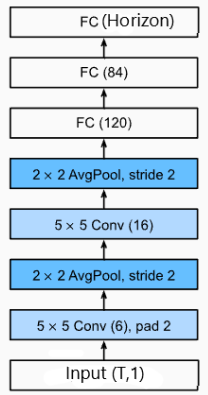

In [55]:
#LeNet-5

LeNet = Sequential()
LeNet.add(Conv1D(input_shape=(T, 1),filters=6,kernel_size=5, padding="same", activation="relu"))
LeNet.add(AveragePooling1D(pool_size=2, strides=2))
LeNet.add(Conv1D(filters=16, kernel_size=5, activation="relu"))
LeNet.add(AveragePooling1D(pool_size=1, strides=2))
LeNet.add(Flatten())
LeNet.add(Dense(units=120,activation="relu"))
LeNet.add(Dense(units=84,activation="relu"))
LeNet.add(Dense(units=HORIZON, activation="linear"))

2022-12-21 13:47:50.038114: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [56]:
LeNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 6)             36        
_________________________________________________________________
average_pooling1d (AveragePo (None, 5, 6)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             496       
_________________________________________________________________
average_pooling1d_1 (Average (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 120)               2040      
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

Here I will be using Adam optimiser to reach to the global minima while training out model. I set lr = 0.0001 with decay rate = 0.00001



In [57]:
opt = Adam(learning_rate=0.0001, decay=1e-5)

LeNet.compile(optimizer=opt, loss='mse')

In [58]:
batch_size = 32
nb_epochs = 20

#Define the number of training steps
total = X_train.size
nb_train_steps = total//batch_size

In [59]:
checkpoint = ModelCheckpoint("LeNet_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
history = LeNet.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=nb_epochs, 
                        steps_per_epoch=nb_train_steps,
                        validation_data= (X_valid, y_valid),
                        callbacks=[checkpoint,early],
                        verbose=1)

2022-12-21 13:48:11.152354: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
7301/7301 [==============================] - 36s 5ms/step - loss: 0.0043 - val_loss: 4.1515e-04

Epoch 00001: val_loss improved from inf to 0.00042, saving model to LeNet_1.h5
Epoch 2/20
7301/7301 [==============================] - 36s 5ms/step - loss: 4.5726e-04 - val_loss: 2.7502e-04

Epoch 00002: val_loss improved from 0.00042 to 0.00028, saving model to LeNet_1.h5
Epoch 3/20
7301/7301 [==============================] - 0s 33us/step - loss: 3.4670e-04 - val_loss: 2.7643e-04

Epoch 00003: val_loss did not improve from 0.00028


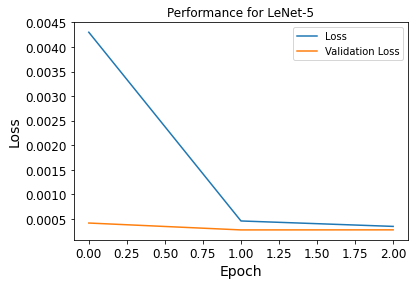

In [60]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Performance for LeNet-5")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss","loss"])
plt.show()

In [61]:
#Make predictions on test set
predictions_1 = LeNet.predict(X_test)
#Compare predictions to observed values
eval_df_1 = pd.DataFrame(predictions_1, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df_1['timestamp'] = test_shifted.index
eval_df_1 = pd.melt(eval_df_1, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df_1['actual'] = np.transpose(y_test).ravel()
eval_df_1[['prediction', 'actual']] = scaler.inverse_transform(eval_df_1[['prediction', 'actual']])
eval_df_1.head()

,timestamp,h,prediction,actual
0,2014-11-01 09:00:00,t+1,"3,451.23","3,436.00"
1,2014-11-01 10:00:00,t+1,"3,476.13","3,464.00"
2,2014-11-01 11:00:00,t+1,"3,463.27","3,439.00"
3,2014-11-01 12:00:00,t+1,"3,395.86","3,407.00"
4,2014-11-01 13:00:00,t+1,"3,376.21","3,389.00"


In [62]:
#Compute the mean absolute percentage error over all predictions
mape(eval_df_1['prediction'], eval_df_1['actual'])

0.012136513163537777

In [63]:
#best_epoch = np.argmin(np.array(history.history['val_loss']))+1
#LeNet.load_weights("LeNet_1.h5".format(best_epoch))

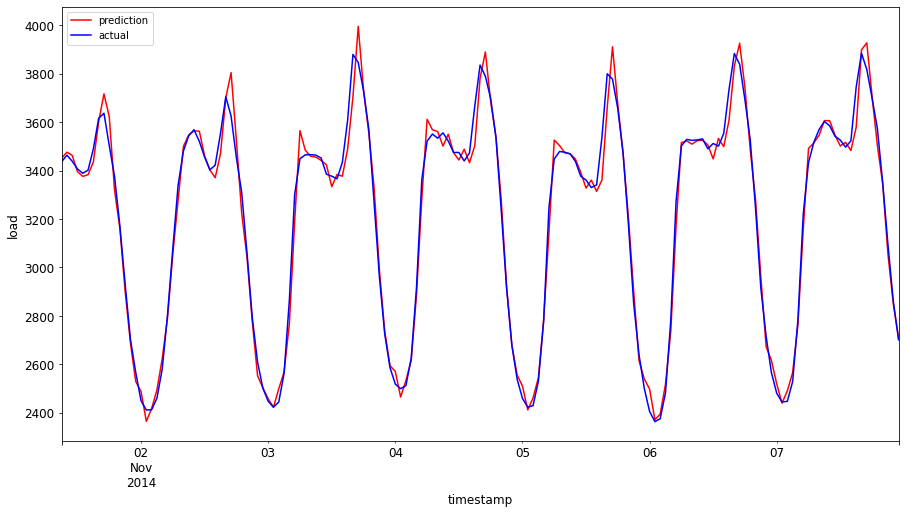

In [63]:
#Plot the predictions vs the observed values for the first week of the test set
eval_df_1[eval_df_1.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

**Stacking**

In [78]:
#All Predictions 
Predictions = predictions_0*0.25 + predictions_1*0.75
#Compare predictions to observed values
eval_df_stack = pd.DataFrame(Predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df_stack['timestamp'] = test_shifted.index
eval_df_stack = pd.melt(eval_df_stack, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df_stack['actual'] = np.transpose(y_test).ravel()
eval_df_stack[['prediction', 'actual']] = scaler.inverse_transform(eval_df_stack[['prediction', 'actual']])
eval_df_stack.head()

,timestamp,h,prediction,actual
0,2014-11-01 09:00:00,t+1,"3,459.18","3,436.00"
1,2014-11-01 10:00:00,t+1,"3,473.62","3,464.00"
2,2014-11-01 11:00:00,t+1,"3,465.41","3,439.00"
3,2014-11-01 12:00:00,t+1,"3,394.25","3,407.00"
4,2014-11-01 13:00:00,t+1,"3,375.96","3,389.00"


In [79]:
#Compute the mean absolute percentage error over all predictions
mape(eval_df_stack['prediction'], eval_df_stack['actual'])

0.011708310089243938

Stacking the models introduces a very slight improvement to performance. However, we know that in a competitive context (e.g. Kaggle) even such very modest improvements could be beneficial

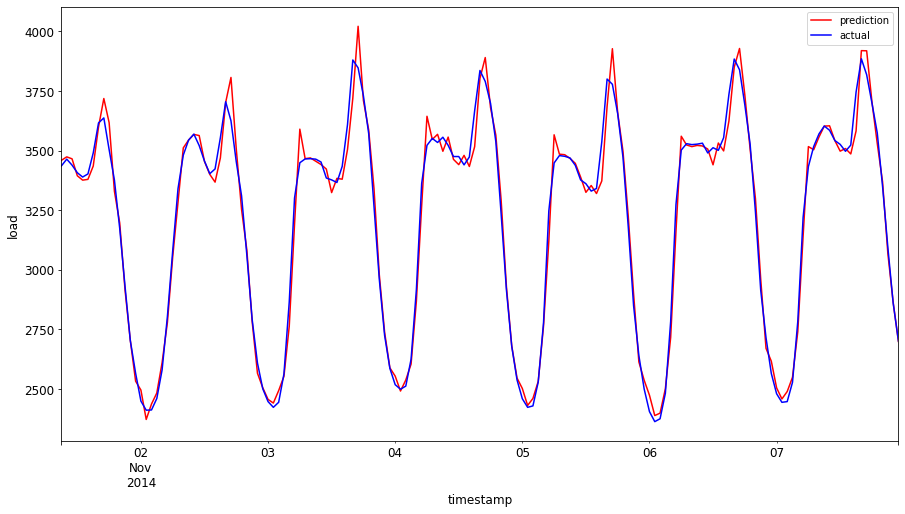

In [80]:
#Plot the predictions vs the observed values for the first week of the test set
eval_df_stack[eval_df_stack.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()